<a href="https://colab.research.google.com/github/ummeasalma/Big-Data/blob/main/hw8_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 92.5% of accuacy with 100 labels

## Goal

In thie programming assignment, we use an example to show how we can use autoencoders and clustering to improve classification results.

We use the mnist data set for this purpose. We are only allowed to lable 100 images from the training data set. But we are free to choose which 100 images to label.

Given this limitation, we will combine autoencoders and clustering to reach a classification accuracy above 92.5%.

## Grading Policy

This programming assignment is graded based on the achieved test accuracy. Any accuracy above 92.5% is graded as 100, whereas any accuracy below 97.5% is graded as 0. Any accuracy in between will be graded using the formula

(test_acc - 0.915)*10000

## Load the data

First, we load the mnist data and normalize the images. Note we use the last 5000 samples in the x_train_full for validation.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


Next, we reshape the images to (28, 28, 1).

In [4]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

We print out the first 100 training images.

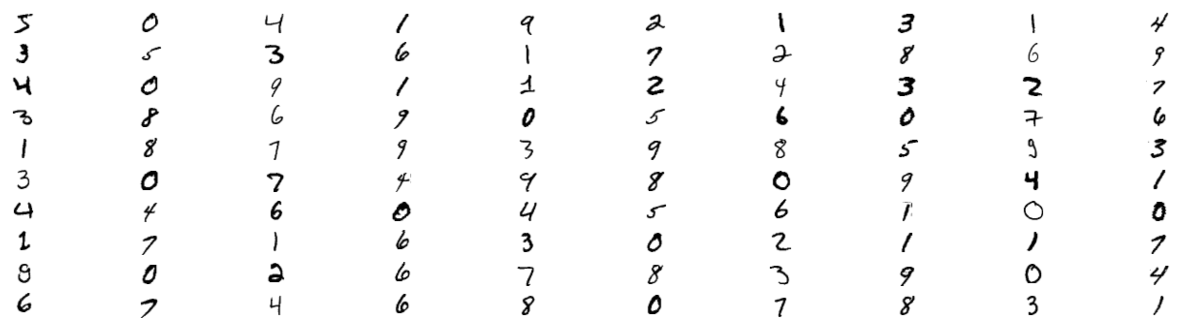

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
for index, digit in enumerate(x_train[:100]):
    plt.subplot(100 // 10, 10, index + 1)
    plt.imshow(digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

# Build  an autoencoder

First import some modules needed for this part of the code.

In [6]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

We build a autoencoder using Conv2D layers.

First, we build the encoder. Hint: study the code from this module. Try different latent_dim settings.

In [7]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 32 #change this value from 16 to 32
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [8]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
x = Dropout(0.5)(x)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [9]:
# shape info needed to build decoder model

shape = K.int_shape(x)

In [10]:
shape

(None, 7, 7, 64)

In [11]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [12]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 32)                100384    
                                                                 
Total params: 119200 (465.62 KB)
Trainable params: 119200 (

Now we build the decoder. Note in the decoder we use Conv2DTranspose layers.

In [13]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [14]:
# stack of Conv2DTranspose()-Conv2DTranspose()
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)


In [15]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [16]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

Combine the encoder and the decoder as the autocoder.

In [17]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 32)                119200    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         159169    
                                                                 
Total params: 278369 (1.06 MB)
Trainable params: 278369 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the autoencoder.

In [18]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

Train the autoencoder. Use restore_best_weights to restore the best weights.

In [19]:

# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_valid, x_valid),
                epochs=100,
                batch_size=batch_size, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/100
1719/1719 [==============================] - 18s 6ms/step - loss: 0.0220 - val_loss: 0.0330
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0301
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0080 - val_loss: 0.0327
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0075 - val_loss: 0.0303
Epoch 5/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0072 - val_loss: 0.0297
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0069 - val_loss: 0.0301
Epoch 7/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0067 - val_loss: 0.0331
Epoch 8/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0066 - val_loss: 0.0318
Epoch 9/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0065 - val_loss: 0.0332
Epoch 10/100
1719/1719 [==============================] - 9s 5ms/step

Plot training and validation losses during the traing.

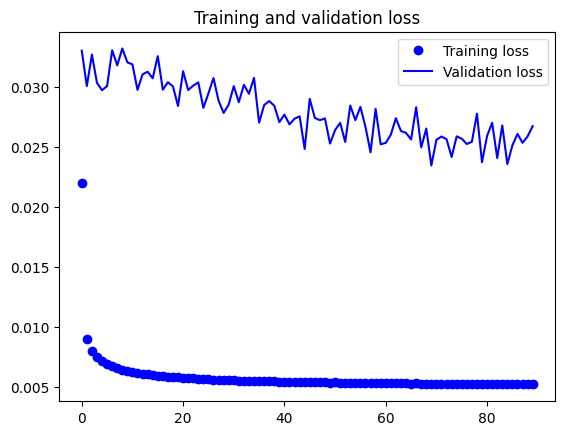

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Obtain the encoded training set and validation set.

In [21]:
x_train_encoded = encoder.predict(x_train)
x_valid_encoded = encoder.predict(x_valid)

print(x_train_encoded.shape, x_valid_encoded.shape)

157/157 [==============================] - 0s 2ms/step
(55000, 32) (5000, 32)


## Cluster encoded training data to select 100 images for labeling

First, we use k-means to find 100 centroids of the encoded training images and label these images.

In [30]:
from sklearn.cluster import KMeans
k = 100
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(x_train_encoded)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
x_representative_digits = x_train[representative_digit_idx]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Display these 100 images.

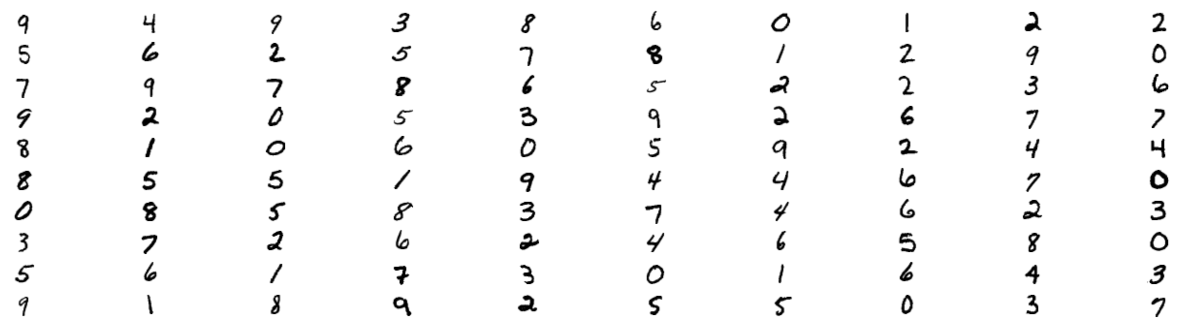

In [31]:
plt.figure(figsize=(16, 4))
for index, x_representative_digits in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(x_representative_digits.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

Print the labels to confirm they are correct.

In [32]:
y_representative_digits = np.empty([k])
for i, idx in enumerate(representative_digit_idx):
  y_representative_digits[i] = y_train[idx]
print(y_representative_digits)

[9. 4. 9. 3. 8. 6. 0. 1. 2. 2. 5. 6. 2. 5. 7. 8. 1. 2. 9. 0. 7. 9. 7. 8.
 6. 5. 2. 2. 3. 6. 9. 2. 0. 5. 3. 9. 2. 6. 7. 7. 8. 1. 0. 6. 0. 5. 9. 2.
 4. 4. 8. 5. 5. 1. 9. 4. 4. 6. 7. 0. 0. 8. 5. 8. 3. 7. 4. 6. 2. 3. 3. 7.
 2. 6. 2. 4. 6. 5. 8. 0. 5. 6. 1. 7. 3. 0. 1. 6. 4. 3. 9. 1. 8. 9. 2. 5.
 5. 0. 3. 7.]


In [33]:
print(x_representative_digits.shape)
print(y_representative_digits.shape)

(28, 28, 1)
(100,)


## Propagate labels and train model for classification

Propagate labels to images that are close to the 100 centroids in the latent space. Hint: study the code provied from the clustering module and try different percentile_closest values.

In [134]:
y_train_propagated = np.empty(len(x_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [135]:
# percentile_closest = 90

# x_cluster_dist = x_digits_dist[np.arange(len(x_train_encoded)), kmeans.labels_]
# for i in range(k):
#     in_cluster = (kmeans.labels_ == i)
#     cluster_dist = x_cluster_dist[in_cluster]
#     cutoff_distance = np.percentile(cluster_dist, percentile_closest)
#     above_cutoff = (x_cluster_dist > cutoff_distance)
#     x_cluster_dist[in_cluster & above_cutoff] = -1

percentile_closest = 100 #90 gives 50, 70 gives 30, 80 gives 0, 92 gives 0, 89 gives 0, 91 gives 0, 75 gives 0, 85 gives 0

x_cluster_dist = np.linalg.norm(x_train_encoded - kmeans.cluster_centers_[kmeans.labels_], axis=1)
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = x_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (x_cluster_dist > cutoff_distance)
    x_cluster_dist[in_cluster & above_cutoff] = -1

Prepare data for classification. Use images with propogated labels and save 5,000 images for validation.  

In [136]:
partially_propagated = (x_cluster_dist != -1)
x_train_partially_propagated = x_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [137]:
print(x_train_partially_propagated.shape)
print(y_train_partially_propagated.shape)

(55000, 28, 28, 1)
(55000,)


In [138]:
x_rep_train = x_train_partially_propagated[:-5000]
y_rep_train = y_train_partially_propagated[:-5000]
x_rep_valid = x_train_partially_propagated[-5000:]
y_rep_valid = y_train_partially_propagated[-5000:]

In [139]:
print(x_rep_train.shape, x_rep_valid.shape)

(50000, 28, 28, 1) (5000, 28, 28, 1)


In [140]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(y_rep_train)
valid_labels = to_categorical(y_rep_valid)
test_labels = to_categorical(y_test)

In [141]:
from keras import layers
from keras import models
from keras.layers import Embedding, LSTM, Bidirectional

def build_model():

    # we build a Y-network model with two inputs and one output
    input_shape = (28, 28, 1)

    left_inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, activation='relu')(left_inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.Flatten()(x)

    right_inputs = layers.Input(shape=input_shape)

    y = layers.Conv2D(64, 7, activation='relu')(right_inputs)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Conv2D(128, 3, activation='relu')(y)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Conv2D(128, 3, activation='relu')(y)
    y = layers.Flatten()(y)

    x = layers.concatenate([x, y])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # outputs
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model([left_inputs, right_inputs], outputs=outputs)
    return model

model = build_model()
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 22, 22, 64)           3200      ['input_17[0][0]']            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 22, 22, 64)           3200      ['input_18[0][0]']            
                                                                                            

Define the image classification model.

In [142]:
model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [143]:
history = model.fit([x_rep_train, x_rep_train], train_labels, validation_data=([x_rep_valid, x_rep_valid], valid_labels), epochs=100, batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)])

Epoch 1/100
1563/1563 [==============================] - 15s 8ms/step - loss: 0.3004 - accuracy: 0.8989 - val_loss: 0.2042 - val_accuracy: 0.9230
Epoch 2/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1870 - accuracy: 0.9342 - val_loss: 0.1709 - val_accuracy: 0.9364
Epoch 3/100
1563/1563 [==============================] - 13s 9ms/step - loss: 0.1578 - accuracy: 0.9435 - val_loss: 0.1531 - val_accuracy: 0.9420
Epoch 4/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1330 - accuracy: 0.9516 - val_loss: 0.1518 - val_accuracy: 0.9440
Epoch 5/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1144 - accuracy: 0.9582 - val_loss: 0.1598 - val_accuracy: 0.9440
Epoch 6/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0993 - accuracy: 0.9634 - val_loss: 0.1520 - val_accuracy: 0.9462
Epoch 7/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0870 - accuracy: 0.9673 - val_loss: 0.1699 -

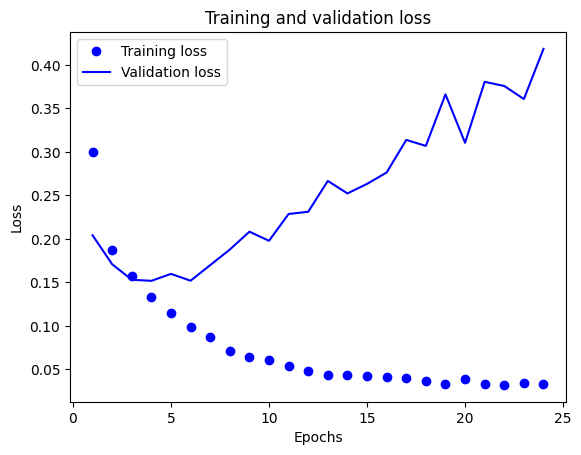

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

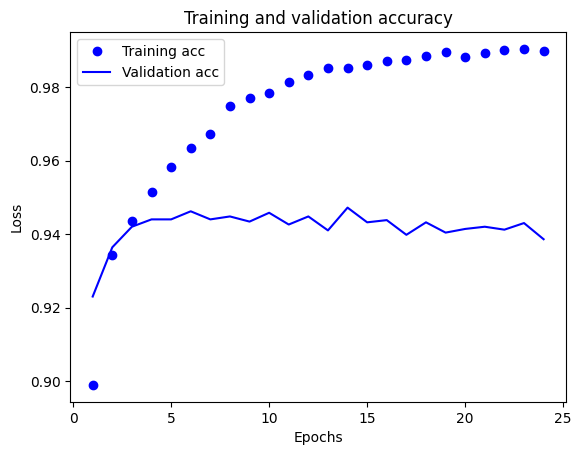

In [145]:
plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Final step: test accuracy and grading

Note, we should only run this step once. We should look at the validation accuracy results before this step. If we are happy with the results, we run this step. Otherwise, we adjust settings in the previous steps until we get satisfying validation accuracy results.

In [146]:
test_loss, test_acc = model.evaluate([x_test, x_test], test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.9053


In [147]:
grade = max(min((test_acc - 0.915)*10000,100), 0)
print('My grade: ', grade)

My grade:  0
